In [100]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
from tqdm.notebook import tqdm, trange
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive
import os
import numpy as np
import warnings
from torchvision import transforms
from torchsummary import summary
from torchvision.io import read_image
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score
warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_file_path = '/content/drive/MyDrive/ROP_datasets/annotations.zip'
# Распаковать архив в текущую папку
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
class ROP_Dataset(Dataset):
    def __init__(self, txt_file, image_dir, transform=None):
        self.image_list = pd.read_csv(txt_file, header=None)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_list.iloc[idx, 0])
        image = Image.open(img_path)
        img_tag = self.image_list.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        sample = {"image": image, "tag": img_tag}

        return image, img_tag

In [5]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD  = torch.tensor([0.229, 0.224, 0.225])

In [79]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Normaliztion
])

# Create Dataset Training
dataset_train = ROP_Dataset(txt_file='./annotations/train_3classes.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Testing
dataset_test = ROP_Dataset(txt_file='./annotations/test_3classes.txt', image_dir='./annotations/images', transform=transform)
# Create Dataset Validation
dataset_valid = ROP_Dataset(txt_file='./annotations/valid_3classes.txt', image_dir='./annotations/images', transform=transform)

# DataLoader Training
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
# DataLoader Testing
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
# DataLoader Validation
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True)

print(next(iter(dataset_train)))

(tensor([[[-1.9295, -1.9638, -1.9467,  ..., -1.9124, -1.9124, -1.9295],
         [-1.9295, -1.9638, -1.9467,  ..., -1.9124, -1.9124, -1.9124],
         [-1.9295, -1.9467, -1.9467,  ..., -1.9295, -1.9124, -1.9124],
         ...,
         [-1.9809, -1.9809, -1.9809,  ..., -1.8439, -1.8268, -1.8268],
         [-1.9638, -1.9638, -1.9980,  ..., -1.8268, -1.8268, -1.8097],
         [-1.9638, -1.9809, -1.9980,  ..., -1.8268, -1.8268, -1.8268]],

        [[-1.8606, -1.8606, -1.8606,  ..., -1.8957, -1.8957, -1.8782],
         [-1.8431, -1.8606, -1.8606,  ..., -1.8957, -1.9132, -1.8957],
         [-1.8431, -1.8606, -1.8606,  ..., -1.8957, -1.8957, -1.8957],
         ...,
         [-1.8957, -1.9132, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
         [-1.8957, -1.9132, -1.9132,  ..., -1.9132, -1.8957, -1.8782],
         [-1.9132, -1.8957, -1.9132,  ..., -1.8957, -1.8957, -1.8957]],

        [[-1.6302, -1.6302, -1.6476,  ..., -1.6999, -1.7173, -1.7347],
         [-1.6302, -1.6476, -1.6650,  ..., -

In [80]:
print(f'Number of training examples: {len(dataset_train)}')
print(f'Number of validation examples: {len(dataset_valid)}')
print(f'Number of test examples: {len(dataset_test)}')

Number of training examples: 344
Number of validation examples: 51
Number of test examples: 104


In [81]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [82]:
import torchvision.models as models
import torch.optim as optim

In [83]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True).to(device)

In [84]:
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [85]:
params = list(model.named_parameters())

# print(params)
for idx in range(len(params)):
    print(params[idx][0],'\t', params[idx][1].size())
print('\n',10*'--')
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.1.0.block.0.0.weight 	 torch.Size([32, 1, 3, 3])
features.1.0.block.0.1.weight 	 torch.Size([32])
features.1.0.block.0.1.bias 	 torch.Size([32])
features.1.0.block.1.fc1.weight 	 torch.Size([8, 32, 1, 1])
features.1.0.block.1.fc1.bias 	 torch.Size([8])
features.1.0.block.1.fc2.weight 	 torch.Size([32, 8, 1, 1])
features.1.0.block.1.fc2.bias 	 torch.Size([32])
features.1.0.block.2.0.weight 	 torch.Size([16, 32, 1, 1])
features.1.0.block.2.1.weight 	 torch.Size([16])
features.1.0.block.2.1.bias 	 torch.Size([16])
features.2.0.block.0.0.weight 	 torch.Size([96, 16, 1, 1])
features.2.0.block.0.1.weight 	 torch.Size([96])
features.2.0.block.0.1.bias 	 torch.Size([96])
features.2.0.block.1.0.weight 	 torch.Size([96, 1, 3, 3])
features.2.0.block.1.1.weight 	 torch.Size([96])
features.2.0.block.1.1.bias 	 torch.Size([96])
features.2.0.block.2.fc1.weight 	 torch.S

In [72]:
def change_num_classes(n, model):
    n_classes = n
    n_fc_in = model.classifier[1].in_features

    model.classifier[1] = nn.Linear(n_fc_in, n_classes).to(device)

    nn.init.xavier_uniform_(model.classifier[1].weight)
    model.classifier[1].bias.data.fill_(0)

In [86]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [15]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [16]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 50

train_loss = torch.zeros(EPOCHS)
valid_loss = torch.zeros(EPOCHS)
train_acc  = torch.zeros(EPOCHS)
valid_acc  = torch.zeros(EPOCHS)

best_valid_loss = float('inf')
best_epoch = 0

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss[epoch], train_acc[epoch] = train(model,
                                                dataloader_train,
                                                optimizer,
                                                criterion,
                                                metric,
                                                device)

    valid_loss[epoch], valid_acc[epoch] = evaluate(model,
                                                   dataloader_valid,
                                                   criterion,
                                                   metric,
                                                   device)

    if valid_loss[epoch] < best_valid_loss:
        best_valid_loss = valid_loss[epoch]
        best_epoch = epoch
        torch.save(model.state_dict(), '_best_model.pt')

    epoch_mins, epoch_secs = epoch_time(start_time, time.monotonic())
    if epoch%2 == 1:    # print every 2 epochs:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss[epoch]:.3f} | Train Acc: {train_acc[epoch]*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss[epoch]:.3f} |  Val. Acc: {valid_acc[epoch]*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.057 | Train Acc: 98.05%
	 Val. Loss: 0.047 |  Val. Acc: 98.96%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 0.026 | Train Acc: 99.61%
	 Val. Loss: 0.048 |  Val. Acc: 98.96%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.018 | Train Acc: 99.80%
	 Val. Loss: 0.044 |  Val. Acc: 98.96%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 23s
	Train Loss: 0.014 | Train Acc: 100.00%
	 Val. Loss: 0.026 |  Val. Acc: 98.96%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 23s
	Train Loss: 0.183 | Train Acc: 93.75%
	 Val. Loss: 0.024 |  Val. Acc: 98.96%


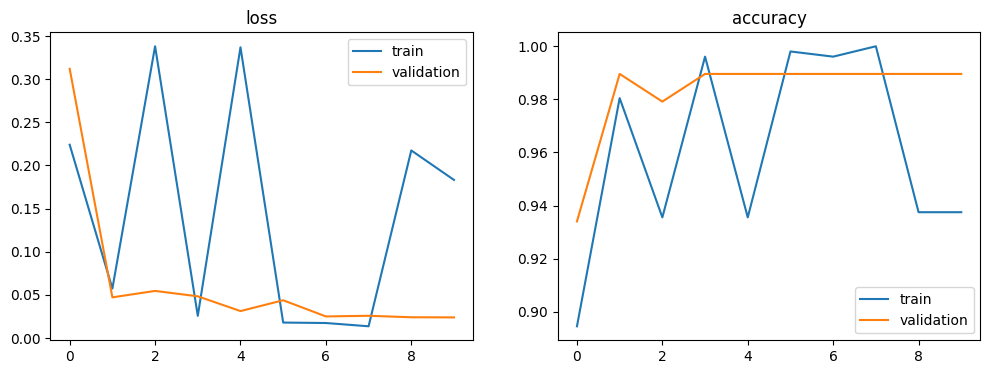

In [ ]:
def plot_results(train_loss, valid_loss, train_acc, valid_acc ):
    fig,axs = plt.subplots(1,2,figsize = (12,4))
    axs[0].plot(train_loss.cpu().numpy(), label = 'train')
    axs[0].plot(valid_loss.cpu().numpy(), label = 'validation')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(train_acc.cpu().numpy(), label = 'train')
    axs[1].plot(valid_acc.cpu().numpy(), label = 'validation')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.show()

plot_results(train_loss, valid_loss, train_acc, valid_acc )

In [87]:
def run_model(learningRate, num_epochs):
    # Define Adam optimizer with the current learning rate
    optimizer = optim.SGD(model.parameters(), lr=learningRate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels = []
        all_predictions = []
        for inputs, labels in dataloader_train:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        # Calculate average training loss per epoch
        epoch_loss = running_loss / len(dataset_train)
        precision = precision_score(all_labels, all_predictions, average='weighted')
        recall = recall_score(all_labels, all_predictions, average='weighted')
        accuracy = accuracy_score(all_labels, all_predictions)
        print(f"Training - Learning Rate: {learningRate} - Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}")

    # Evaluation loop
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader_valid:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"\n\nValidation - Learning Rate: {learningRate}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}\n\n")

    # Testing loop
    # Set model to evaluation mode
    model.eval()

    # Lists to store true labels and predicted labels
    all_labels = []
    all_predictions = []

    # Loop through the test dataset
    with torch.no_grad():
        for inputs, labels in dataloader_test:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Append true labels and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate precision, recall, and accuracy
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    accuracy = accuracy_score(all_labels, all_predictions)

    print(f"\n\nTesting - Learning Rate: {learningRate}, Recall: {recall:.4f}, Precision: {precision:.4f}, Accuracy: {accuracy:.4f}\n\n")

In [ ]:
# Define learning rates
learning_rates = [0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.08]

In [88]:
num_epochs = 30

for lr in learning_rates:
    model = models.efficientnet_b0(weights='IMAGENET1K_V1', progress=True).to(device)
    change_num_classes(3, model)
    run_model(lr, num_epochs)

NameError: name 'learning_rates' is not defined

In [89]:
num_epochs = 30
change_num_classes(3, model)
run_model(0.05, num_epochs)

Training - Learning Rate: 0.05 - Epoch 1/30, Training Loss: 0.8434, Recall: 0.6308, Precision: 0.6073, Accuracy: 0.6308
Training - Learning Rate: 0.05 - Epoch 2/30, Training Loss: 0.4698, Recall: 0.8343, Precision: 0.8465, Accuracy: 0.8343
Training - Learning Rate: 0.05 - Epoch 3/30, Training Loss: 0.2427, Recall: 0.9477, Precision: 0.9486, Accuracy: 0.9477
Training - Learning Rate: 0.05 - Epoch 4/30, Training Loss: 0.1601, Recall: 0.9622, Precision: 0.9631, Accuracy: 0.9622
Training - Learning Rate: 0.05 - Epoch 5/30, Training Loss: 0.0965, Recall: 0.9826, Precision: 0.9826, Accuracy: 0.9826
Training - Learning Rate: 0.05 - Epoch 6/30, Training Loss: 0.0879, Recall: 0.9826, Precision: 0.9828, Accuracy: 0.9826
Training - Learning Rate: 0.05 - Epoch 7/30, Training Loss: 0.0426, Recall: 0.9971, Precision: 0.9971, Accuracy: 0.9971
Training - Learning Rate: 0.05 - Epoch 8/30, Training Loss: 0.0283, Recall: 1.0000, Precision: 1.0000, Accuracy: 1.0000
Training - Learning Rate: 0.05 - Epoch 9

In [90]:
n_classes = 3
n_samples = len(dataloader_test)
names_classes = ["healthy", "stage 2-3", "plus"]

class_correct = torch.zeros(n_classes)
class_total   = torch.zeros(n_classes)

labels   = []
predicts = []

model.eval()

with torch.no_grad():

    for x,y in tqdm(dataloader_test):
        x = x.to(device)
        y = y.to('cpu')

        y_pred = model.forward(x).to('cpu')

        cls_pred = torch.argmax(y_pred, dim=1)

        c = (cls_pred == y).squeeze() # one-hot vector

        for i in range(x.shape[0]):
            label = y[i]
            class_correct[label] += c[i].item()
            class_total[label]   += 1

        labels.append(y)
        predicts.append(cls_pred)

labels   = torch.cat(labels, dim = 0) # make it 1d array
predicts = torch.cat(predicts, dim = 0) # make it 1d array

for i in range(n_classes):
    print('Accuracy of %5s : %2d %%' % (
        names_classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of healthy : 100 %
Accuracy of stage 2-3 : 98 %
Accuracy of  plus : 93 %


In [91]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    print(images.shape)

    filters = filters.cpu()

    n_images  = images.shape[0]
    n_filters = filters.shape[0]
    n_images  = 5
    n_filters = 10

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 20))

    for i in range(n_images)[:4]:

        img = images[i].squeeze(0).numpy().transpose((1,2,0))

        img = 255*(img - img.min())/(img.max() - img.min())

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))

        ax.imshow(img.astype(int), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters)[:10]:
            image = filtered_images[i][j]

            image = image.numpy().astype(float)

            image = 255*(image - image.min())/(image.max() - image.min())

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)

            ax.imshow(image.astype(int), cmap='bone')

            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
    return filtered_images

torch.Size([5, 3, 224, 224])


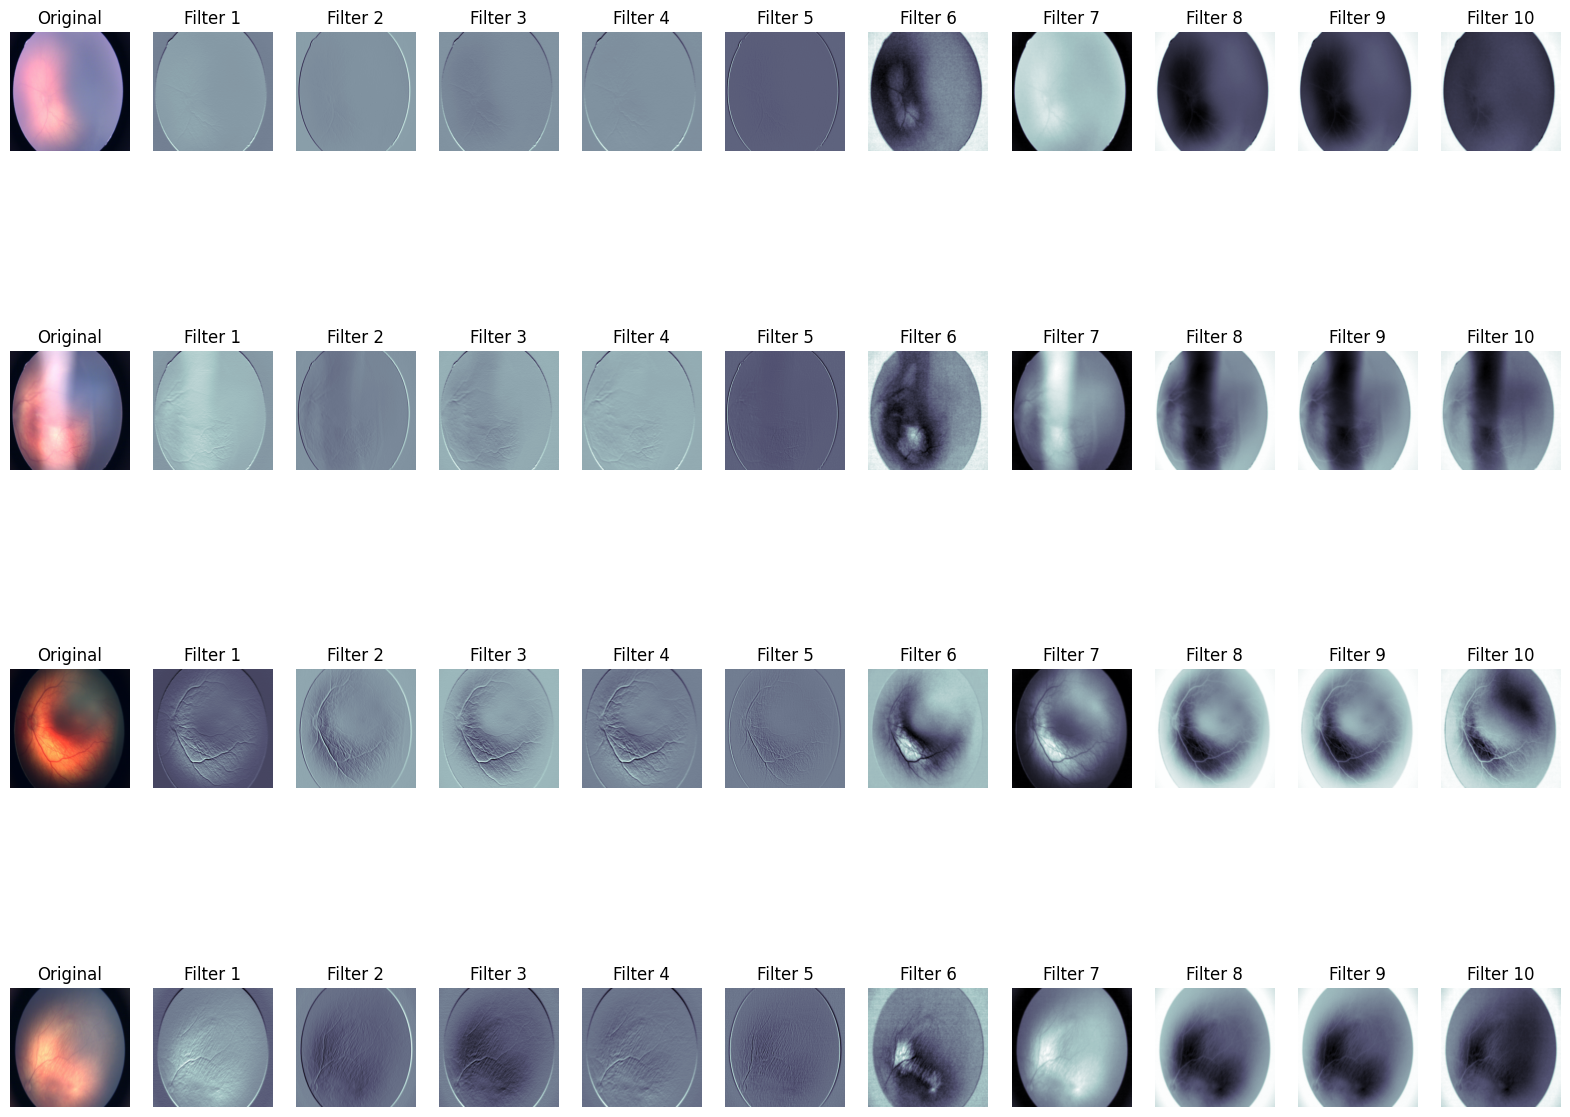

In [92]:
N_IMAGES = 5

images = [image for image, label in [dataset_test[i] for i in range(N_IMAGES)]]

filters = model.features[0][0].weight.data

filtered_images = plot_filtered_images(images, filters)

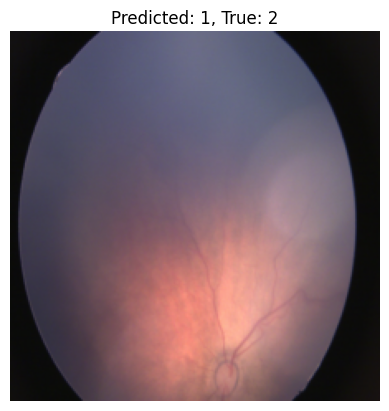

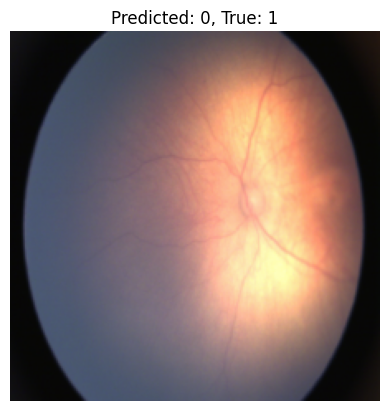

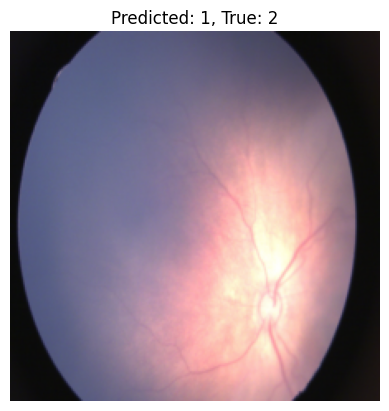

In [114]:
with torch.no_grad():
    model.eval()
    for inputs, labels in dataloader_test:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)
        # print(predicted)
        # print(labels)

        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
                image = unnormalize(inputs)
                image = image.data.cpu().numpy()[i].transpose(1,2,0)
                plt.imshow(image)
                plt.title(f"Predicted: {predicted[i]}, True: {labels[i]}")
                plt.axis('off'); plt.show()